In [1]:
from DeltaT import DeltaT, DeltaT_with_error_estimate
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

## Examples of Delta T calculation with error estimate

In [2]:
DeltaT_with_error_estimate(2018.7)

'69.18 ± 0.05 seconds'

In [3]:
DeltaT_with_error_estimate([-800, 1942.5, 523.6, 2232])

['21769 ± 360 seconds',
 '25.63 ± 0.05 seconds',
 '5364 ± 40 seconds',
 '211 ± 20 seconds']

In [4]:
# Comparison with the second table in http://astro.ukho.gov.uk/nao/lvm/
y = np.arange(-700, 1700, 100)
df = pd.DataFrame({'y':y, 'DeltaT':DeltaT_with_error_estimate(y)})
display(df)

,y,DeltaT
0,-700,20050 ± 170 seconds
1,-600,18468 ± 160 seconds
2,-500,16940 ± 150 seconds
3,-400,15474 ± 130 seconds
4,-300,14081 ± 120 seconds
5,-200,12773 ± 110 seconds
6,-100,11558 ± 100 seconds
7,0,10441 ± 90 seconds
8,100,9405 ± 80 seconds
9,200,8425 ± 70 seconds


In [5]:
# Comparison with the 4th table in http://astro.ukho.gov.uk/nao/lvm/
y = np.arange(1800, 1901, 10)
df = pd.DataFrame({'y':y, 'DeltaT':DeltaT_with_error_estimate(y)})
display(df)

,y,DeltaT
0,1800,18.4 ± 0.5 seconds
1,1810,15.7 ± 0.2 seconds
2,1820,16.5 ± 0.2 seconds
3,1830,10.8 ± 0.2 seconds
4,1840,7.6 ± 0.1 seconds
5,1850,9.3 ± 0.1 seconds
6,1860,9.0 ± 0.1 seconds
7,1870,2.37 ± 0.05 seconds
8,1880,-3.21 ± 0.05 seconds
9,1890,-3.88 ± 0.05 seconds


## Delta T Plot

Plot Delta T from y=1500 to y=2200

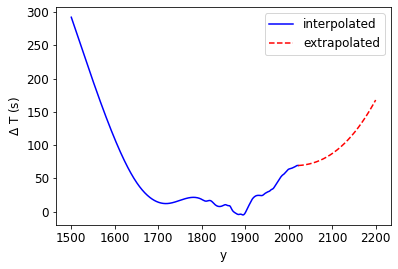

In [6]:
plt.rcParams.update({'font.size': 12})
yint = np.arange(1500,2023)
yext = np.arange(2022, 2201)
plt.plot(yint, DeltaT(yint), '-b', label='interpolated')
plt.plot(yext, DeltaT(yext), '--r', label='extrapolated')
plt.xlabel('y')
plt.ylabel(r'$\Delta$ T (s)')
plt.legend()
plt.show()

## Error of the extrapolation formula for y > 2022

Daily values of Delta T in 1972 and later can be constructed from the data published in [IERS Bulletin B](https://www.iers.org/IERS/EN/Publications/Bulletins/bulletins.html). 

The csv file "DeltaT_IERS.csv" contains data of Delta T from Jan 1972 to September 1, 2022 compiled from the IERS files. It has the following columns:
- year, month, day: UT1 date
- MJD: UT1 Julian date number - 2400000.5
- UT1_UTC: Value of UT1 - UTC in sec
- sigma: estimated error of UT1 in sec
- DeltaT: Delta T computed from (TT - UTC) - (UT1 - UTC) 
           = 42.184s + (accumulated leap seconds) - (UT1 - UTC)

The data in this csv file can be used to calculate the error of the extrapolation formula for Delta T for y > 2022.

Value of y may be obtained from MJD using the fact that the MJD of 2000-Jan-1 0h is 51544 and there are 365.2425 days in a Gregorian year on average:
y = (MJD - 51544)/365.2425 + 2000

In [7]:
df = pd.read_csv("DeltaT_IERS.csv")
df['y'] = (df['MJD'] - 51544)/365.2425 + 2000
df = df[df.y > 2022].copy()
df['eps'] = DeltaT(df['y']) - df['DeltaT']
df[['y','eps']].describe()

,y,eps
count,244.000000,244.000000
mean,2022.334476,0.023738
std,0.193244,0.035068
min,2022.001821,-0.015794
25%,2022.168149,-0.001781
50%,2022.334476,0.010222
75%,2022.500804,0.047032
max,2022.667132,0.107008


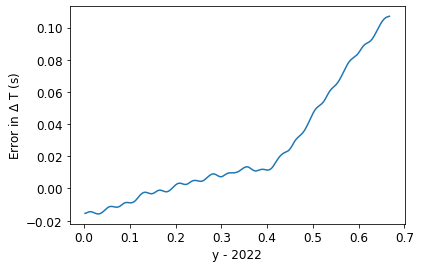

In [8]:
plt.plot(df['y'] - 2022, df['eps'])
plt.xlabel("y - 2022")
plt.ylabel(r"Error in $\Delta$ T (s)")
plt.show()

We see that for y > 2022 (up to September 1, 2022), the maximum error of the extrapolated Delta T is 0.107 seconds in magnitude, the mean is 0.024 seconds and std is 0.035 seconds. The root-mean-square error is sqrt(0.024^2+0.035^2) = 0.042 seconds.